This notebook calculates the average similarity between the embeddings of the three different datasets - the original TruthfulQA misconceptions dataset, the crafted, and generated. Optionally, this comparison also includes the provided answer options in addition to the dataset questions.


## Settings


In [1]:
# Whether to include the answers to questions when calculating similarity.
EMBED_QUESTION_ANSWERS: bool = True

## Utilities


In [2]:
# Standard to handle notebooks being stored in a subdirectory
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

!pip install -U sentence-transformers
!pip install datasets==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 2.5 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.2.0
    Uninstalling fsspec-2024.2.0:
      Successfully uninstalled fsspec-2024.2.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.1

In [3]:
import datasets
import numpy as np
import scipy as sp
import prettytable
import sentence_transformers
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

def load_truthfulqa(category=None):
    ds = datasets.load_dataset("truthful_qa", "multiple_choice")["validation"]
    if category and category != "all":
        # The multiple_choice dataset does not have a category field, so we need to filter on the generation dataset
        filtered_ds = datasets.load_dataset("truthful_qa", "generation")
        filtered_ds = filtered_ds.filter(
            lambda x: x["category"].lower() == category.lower()
        )
        filtered_questions = filtered_ds["validation"]["question"]
        ds = ds.filter(lambda x: x["question"] in filtered_questions)
    return ds

In [4]:
embedding_model = sentence_transformers.SentenceTransformer(
    "all-mpnet-base-v2", device="cpu"
)


def embed(text: str) -> np.array:
    return embedding_model.encode(text, convert_to_tensor=True).numpy()


def get_truthfulqa_dataset_embeddings(
    truthfulqa_dataset: datasets.Dataset,
    exclude_choices: bool = not EMBED_QUESTION_ANSWERS,
) -> np.array:
    """
    Embed elements from a dataset that uses the TruthfulQA structure.

    Args:
        truthfulqa_dataset (datasets.Dataset): The dataset to embed.
        exclude_choices (bool, optional): If this is True, only the
            questions will be embedded. If this is False, the questions
            and choices will be embedded. Defaults to False.
    """
    if exclude_choices:
        texts = truthfulqa_dataset["question"]
    else:
        texts = [
            "\n".join([x["question"]] + sorted(x["mc1_targets"]["choices"]))
            for x in truthfulqa_dataset
        ]
    return embedding_model.encode(texts)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Example
s1 = "What is the capital of France?"
s2 = "Which is the largest city of the French nation?"
s3 = "When did mankind first step foot on the moon?"

e1 = embed(s1)
e2 = embed(s2)
e3 = embed(s3)

print(sentence_transformers.util.pytorch_cos_sim(e1, e2))
print(sentence_transformers.util.pytorch_cos_sim(e1, e3))
print(sentence_transformers.util.pytorch_cos_sim(e2, e3))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.8227]])
tensor([[0.2015]])
tensor([[0.1572]])


In [6]:
def nondiag_mean(arr2d: np.array) -> float:
    return arr2d[~np.eye(arr2d.shape[0], dtype=bool)].mean()


def self_similarity(embs: np.array) -> float:
    sims = sentence_transformers.util.cos_sim(embs, embs).numpy()
    return nondiag_mean(sims)


def cross_similarity(embs1: np.array, embs2: np.array) -> float:
    sims = sentence_transformers.util.cos_sim(embs1, embs2).numpy()
    return np.mean(sims)

## Analysis


In [7]:
# 1. Load datasets
# @TODO Make utilities for these.

truthful_dataset = load_truthfulqa("misconceptions")
crafted_ds = datasets.load_dataset(
    "json", data_files="../input/holdout/crafted_dataset_unfiltered.jsonl"
)["train"]
generated_ds = datasets.load_dataset(
    "csv", data_files="../input/holdout/generated_dataset_unfiltered.csv"
)["train"]

## what's this for?
def array(x, dtype=None):
    return x


# Special logic due to how the CSV stores choices as a string
generated_ds = generated_ds.map(
    lambda x: {
        "question": x["question"],
        "mc1_targets": eval(x["mc1_targets"], dict(globals(), array=array), locals()),
    }
)

dss = [truthful_dataset, crafted_ds, generated_ds]
dss_names = ["Orig", "Craft", "Gen"]
# dss = [crafted_ds, generated_ds]
# dss_names = ["Craft", "Gen"]

print("Dataset shapes", [ds.shape for ds in dss])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/817 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset shapes [(100, 3), (24, 2), (99, 3)]


In [8]:
# 2. Embed each item

## why is the function called "get_truthfulqa..." if we are using it for both the target and the retro-holdout?
all_embeddings = [get_truthfulqa_dataset_embeddings(ds) for ds in dss]

print([embs.shape[0] for embs in all_embeddings])

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

[100, 24, 99]


In [9]:
# 3. Calculate all pairwise cosine similarities, report the mean for each dataset combination

self_similarities = [self_similarity(embs) for embs in all_embeddings]

cross_similarities = [
    [
        self_similarity(embs1) if embs1 is embs2 else cross_similarity(embs1, embs2)
        for embs2 in all_embeddings
    ]
    for embs1 in all_embeddings
]

In [10]:
# 4. Define functions for pulling random embeddings without replacement

def draw_n_once(embs: np.array, n: int) -> np.array:
    index = np.random.choice(embs.shape[0], n, replace=False)
    return embs[np.sort(index), :]


def draw_n_twice(embs: np.array, n: int) -> list:
    index = np.random.choice(embs.shape[0], 2 * n, replace=False)
    return [embs[np.sort(index[0:n]), :], embs[np.sort(index[n:2*n]), :]]


def draw_n_once_mean(embs: np.array, n: int) -> np.array:
    index = np.random.choice(embs.shape[0], n, replace=False)
    return np.mean(embs[index, :], axis = 0)


def draw_n_twice_mean(embs: np.array, n: int) -> list:
    index = np.random.choice(embs.shape[0], 2 * n, replace=False)
    return [np.mean(embs[index[0:n], :], axis = 0), np.mean(embs[index[n:2*n], :], axis = 0)]

In [11]:
# 5. 

N = 50000
# num = min([embs.shape[0] for embs in all_embeddings])//3
num = 1

sim_dists = [np.array([]), np.array([])]

for i in range(N):
    outlist = draw_n_twice_mean(all_embeddings[1], num)
    sim_dists[0] = np.append(sim_dists[0], sentence_transformers.util.cos_sim(outlist[0], outlist[1]))
    
    outlist = [draw_n_once_mean(all_embeddings[0], num), draw_n_once_mean(all_embeddings[1], num)]
    sim_dists[1] = np.append(sim_dists[1], sentence_transformers.util.cos_sim(outlist[0], outlist[1]))

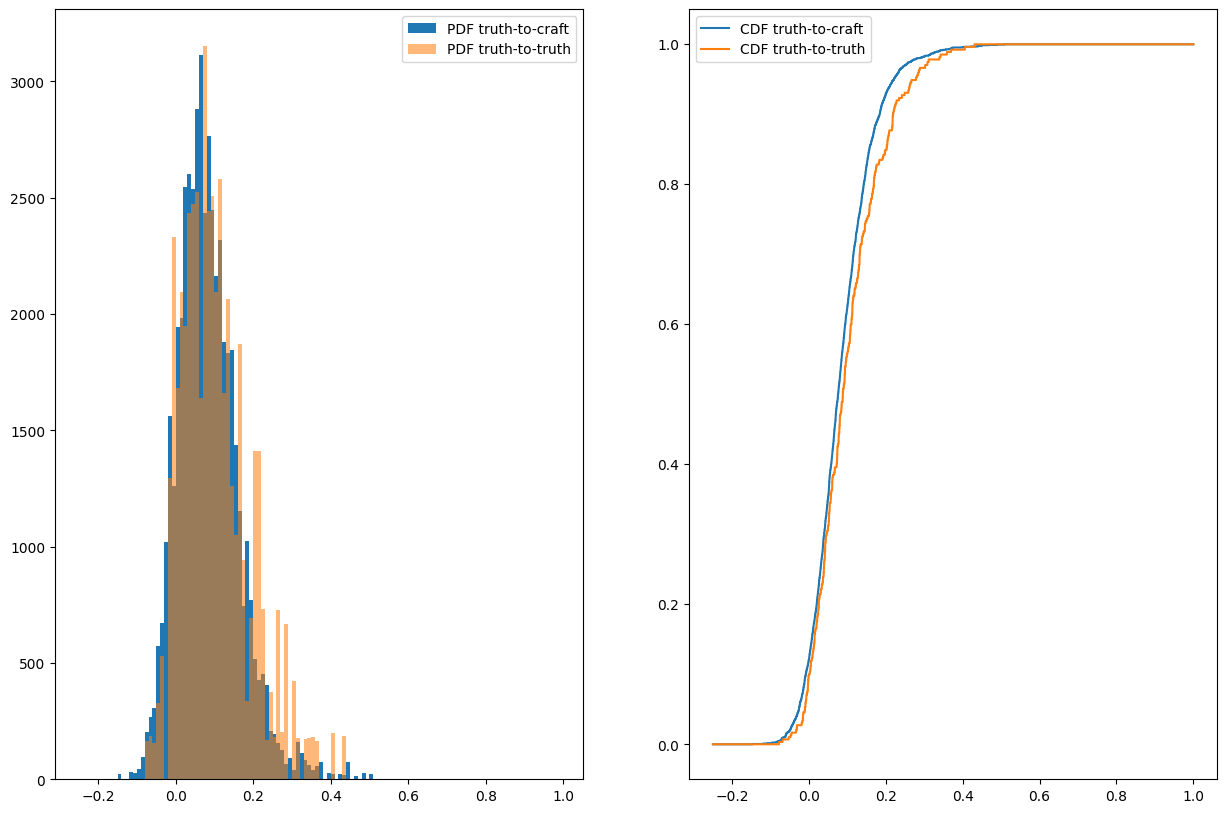

In [12]:
# 6. Basic EDF Plot

fig, ax = plt.subplots(1,2,figsize=(15,10))

# PDFs
counts0, bins0 = np.histogram(sim_dists[0], np.arange(-.25, 1, .01))
counts1, bins1 = np.histogram(sim_dists[1], np.arange(-.25, 1, .01))
ax[0].stairs(counts1, bins1, fill=True, label="PDF truth-to-craft") # left plot, blue = TruthfulQA to WithheldQA-craft
ax[0].stairs(counts0, bins0, fill=True, alpha=0.55, label="PDF truth-to-truth") # left plot, orange = TruthfulQA to self

# CDFs
counts0, bins0 = np.histogram(sim_dists[0], np.arange(-.25, 1, .00005))
counts1, bins1 = np.histogram(sim_dists[1], np.arange(-.25, 1, .00005))

pdf0 = counts0/sum(counts0)
cdf0 = np.cumsum(pdf0)

pdf1 = counts1/sum(counts1)
cdf1 = np.cumsum(pdf1)

ax[1].plot(bins1[1:], cdf1, label="CDF truth-to-craft") # right plot, blue = TruthfulQA to WithheldQA-craft
ax[1].plot(bins0[1:], cdf0, label="CDF truth-to-truth") # right plot, orange = TruthfulQA to self


ax[0].legend()
ax[1].legend()
plt.show()

In [13]:
res = sp.stats.anderson_ksamp(sim_dists)
if res.pvalue < .05:
    out = f'Because the test statistic is greater than\nthe critical p-value for 5%, {res.statistic:.3f} > 1.961,\nwe can say that the two samples were not drawn\nfrom the same distribution with statistical significance.\n'
else:
    out = f'Because the test statistic is less than\nthe critical p-value for 5%, {res.statistic:.3f} > 1.961,\nwe cannot say that the two samples were drawn from\nthe same distribution with statistical significance.\n'

print(out)
print("Statistic = " + str(res.statistic))
print("P-Value = " + str(res.pvalue))
print("Critical Values = " + str(res.critical_values))


Because the test statistic is greater than
the critical p-value for 5%, 639.075 > 1.961,
we can say that the two samples were not drawn
from the same distribution with statistical significance.

Statistic = 639.0754505822099
P-Value = 0.001
Critical Values = [0.325 1.226 1.961 2.718 3.752 4.592 6.546]


/tmp/ipykernel_33/2984740556.py:1: UserWarning: p-value floored: true value smaller than 0.001
  res = sp.stats.anderson_ksamp(sim_dists)


In [14]:
def self_sim_mat(embs: np.array) -> float:
    # INPUT: NxA matrix of N embbeddings; each row is a different prompt
    # OUTPUT: NxN masked matrix w/ the diagonal masked; 
        # each row (i) is the cosine similarity between the 
        # (i)th embedding and each (other) embedding in the input matrix;
        # the entry corresponding to cosine similarity with itself is masked
    sims = sentence_transformers.util.cos_sim(embs, embs).numpy()
    return np.ma.masked_array(sims,np.eye(sims.shape[0], dtype=bool))

# JUST USE self_sim_mat(INPUT).compressed()
# def self_sim_vec(embs: np.array) -> float:
#     # INPUT: NxA matrix of N embbeddings; each row is a different prompt
#     # OUTPUT: N*(N-1)x1 vector which is the 1-dimensional representation
#         # of the output provided by the self_sim_mat function;
#         # note that elements masked in the self_sim_mat output
#         # are removed from this function's output
#     sims = sentence_transformers.util.cos_sim(embs, embs).numpy()
#     return sims[~np.eye(sims.shape[0], dtype=bool)]


def cross_sim_vec(embs1: np.array, embs2: np.array) -> float:
    # INPUT: 
        # embs1 ~ NxA matrix of N embbeddings; each row is a different prompt
        # embs2 ~ MxA matrix of M embbeddings; each row is a different prompt
    # OUTPUT: N*Mx1 vector which is the 1-dimensional representation of the
        # cosine similarities between embeddings (rows) in embs1 and embs2;
        # note that sims is an NxM matrix representation
    sims = sentence_transformers.util.cos_sim(embs1, embs2).numpy()
    return sims.flatten()


def shuffle_pull_fixed(embs: np.array, samp_size: int, num_samples: int):
    # INPUTS: 
        # embs ~ NxA matrix of N embbeddings; each row is a different prompt
        # samp_size ~ the number of rows to draw for each sample (dimension 1 of output matrix)
        # num_samples ~ number of samples to take (dimension 3 of output matrix) 
    # OUTPUT: (samp_size)x(num_samples)x(num_samples) masked matrix;
        # each layer (constant value in dimension 3) is the masked self similarity matrix
        # of (samp_size) embeddings randomly chosen from the input matrix of embeddings
    similarities = np.ma.zeros((num_samples, samp_size, samp_size))
    for i in range(num_samples):
        np.random.shuffle(embs)
        similarities[i] = self_sim_mat(embs[:samp_size,:])
    return similarities


# def shuffle_pull_varied(embs: np.array, samp_min: int, samp_max, num_samples: int):
#     similarities = np.zeros((num_samples,1))
#     for i in range(num_samples):
#         np.random.shuffle(embs)
#         num = np.random.choice(samp_max-samp_min, size=1, replace=False)+samp_min
#         similarities[i] = self_sim_mat(embs[:num[0],:])
#     return similarities
# N = 10
# min_pulls = 10
# max_pulls = all_embeddings[1].shape[0]
# fixed_pulls = all_embeddings[1].shape[0]-9  

In [15]:
# np.set_printoptions(threshold=sys.maxsize)

# Create Combined Datasets
truthcraft = np.concatenate((all_embeddings[0], all_embeddings[1]), axis = 0)
truthgen = np.concatenate((all_embeddings[0], all_embeddings[2]), axis = 0)

combined_cos_sim = shuffle_pull_fixed(truthcraft, 124, 1)

In [16]:

bench_sims = []
bench_sims.append(combined_cos_sim.compressed()) # self similarities of COMBINED
bench_sims.append(cross_sim_vec(truthcraft, all_embeddings[1])) # cross similarities of COMBINED-to-RETRO
bench_sims.append(cross_sim_vec(all_embeddings[0], all_embeddings[1])) # cross similarities of TARGET-to-RETRO
bench_sims.append(self_sim_mat(all_embeddings[0]).compressed()) # self-similarities of TARGET
bench_sims.append(self_sim_mat(all_embeddings[1]).compressed()) # self-similarities of RETRO

s = 24
N = 20000

big_mat = shuffle_pull_fixed(truthcraft, s, N)
# print(big_mat[1].view(np.ma.MaskedArray))

In [17]:
# Calculate the AK test statistic for determining whether each random sampling of 
# embeddings (layer) could have been pulled from the distribution in the COMBINED dataset
    # shorthand: random_samples(COMBINED,len(RETRO))🠖COMBINED
out = np.zeros(N,)
for i in range(N):
#     counts, bins = np.histogram(big_mat[i], np.arange(-.25, 1, .05))
#     pdf = counts/sum(counts)
#     cdf = np.cumsum(pdf)
    out[i] = sp.stats.anderson_ksamp([bench_sims[0], big_mat[i].compressed()]).statistic
#     out[i] = np.mean(big_mat[i].compressed())

/tmp/ipykernel_33/1413180499.py:9: UserWarning: p-value floored: true value smaller than 0.001
  out[i] = sp.stats.anderson_ksamp([bench_sims[0], big_mat[i].compressed()]).statistic
/tmp/ipykernel_33/1413180499.py:9: UserWarning: p-value capped: true value larger than 0.25
  out[i] = sp.stats.anderson_ksamp([bench_sims[0], big_mat[i].compressed()]).statistic


In [18]:
# Create a KDE using the samples
model = KernelDensity(bandwidth=2, kernel='gaussian')
model.fit(out.reshape(-1,1))

xstart = -2
values = np.arange(xstart, max(out), .1)

probabilities = model.score_samples(values.reshape(-1,1))
probabilities = np.exp(probabilities)

In [19]:
# Calculate the AK test statistic for determining whether RETRO
# could have been pulled from the distribution in the COMBINED dataset
    # shorthand: AK(random_samples(COMBINED,len(RETRO))🠖COMBINED)
res = sp.stats.anderson_ksamp([bench_sims[0], bench_sims[1]])
print("Statistic = " + str(res.statistic))
print("P-Value = " + str(res.pvalue))
print("Critical Values = " + str(res.critical_values))
statistic = res.statistic

# statistic = np.mean(bench_sims[1])

Statistic = 11.097110125464686
P-Value = 0.001
Critical Values = [0.325 1.226 1.961 2.718 3.752 4.592 6.546]


/tmp/ipykernel_33/2555439343.py:4: UserWarning: p-value floored: true value smaller than 0.001
  res = sp.stats.anderson_ksamp([bench_sims[0], bench_sims[1]])


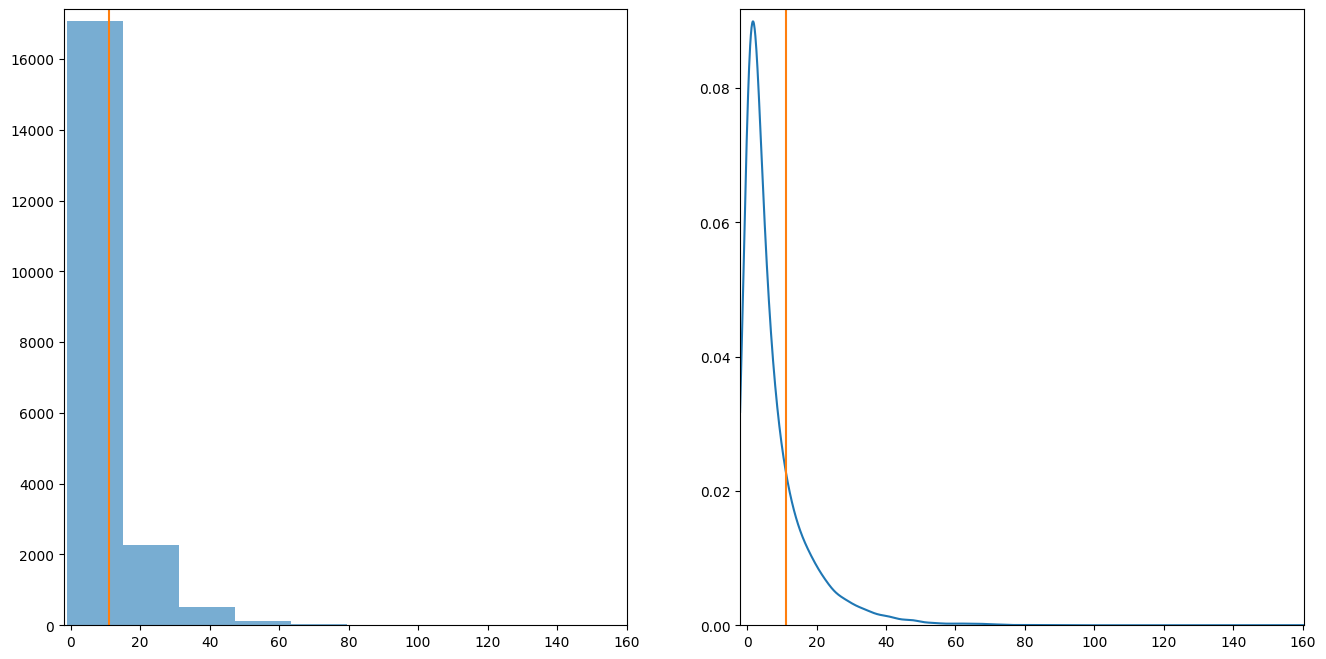

In [20]:
# Plots

fig, ax = plt.subplots(1,2,figsize=(16,8))

# LEFT PLOT: histogram of AK(random_samples(COMBINED,len(RETRO))🠖COMBINED);
# orange line is AK(Retro🠖COMBINED)
counts, bins = np.histogram(out)
ymax = 1.02*max(counts)
ax[0].stairs(counts, bins, fill=True, alpha=.6)
ax[0].plot([statistic, statistic], [0, ymax])
ax[0].set_xlim(xstart,max(out))
ax[0].set_ylim(0, ymax)


# RIGHT PLOT: KDE of AK(random_samples(COMBINED,len(RETRO))🠖COMBINED);
# orange line is AK(Retro🠖COMBINED)
ymax = 1.02*max(probabilities)
ax[1].plot(values[:], probabilities)
ax[1].plot([statistic, statistic], [0, ymax])
ax[1].set_xlim(xstart,max(out))
ax[1].set_ylim(0, ymax)

plt.show()

In [21]:
pval = (out > statistic).mean()

z = 2.576

# p-Value 99% confidence interval
conf = z*np.sqrt((pval*(1-pval))/N)

print(f'[{pval-conf},{pval+conf}]')

[0.20850423836110032,0.22349576163889967]


NameError: name 'all_sims' is not defined

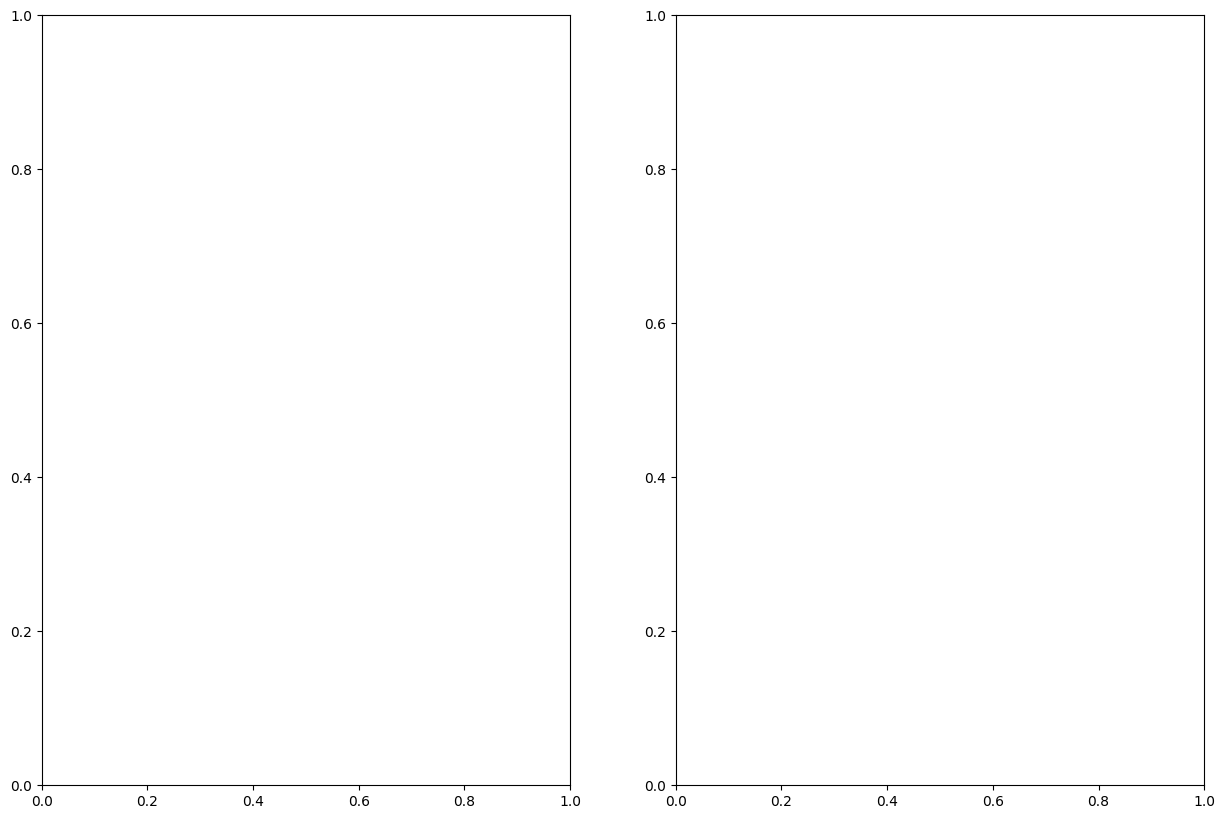

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,10))

# PDFs
counts0, bins0 = np.histogram(all_sims[0], np.arange(-.25, 1, .05))
counts1, bins1 = np.histogram(all_sims[1], np.arange(-.25, 1, .05))
ax[0].stairs(counts1/sum(counts1), bins1, fill=True, label="PDF truth-to-craft") # left plot, blue = TruthfulQA to WithheldQA-craft
ax[0].stairs(counts0/sum(counts0), bins0, fill=True, alpha=0.55, label="PDF truth-to-truth") # left plot, orange = TruthfulQA to self

# CDFs
counts0, bins0 = np.histogram(all_sims[0], np.arange(-.25, 1, .00005))
counts1, bins1 = np.histogram(all_sims[1], np.arange(-.25, 1, .00005))

pdf0 = counts0/sum(counts0)
cdf0 = np.cumsum(pdf0)

pdf1 = counts1/sum(counts1)
cdf1 = np.cumsum(pdf1)

ax[1].plot(bins1[1:], cdf1, label="CDF truth-to-craft") # right plot, blue = TruthfulQA to WithheldQA-craft
ax[1].plot(bins0[1:], cdf0, label="CDF truth-to-truth") # right plot, orange = TruthfulQA to self


ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
# num_samp = truthcraft.shape[0]
# comparisons = np.zeros((num_samp, num_samp-1))
# for i in range(num_samp): # for each entry
#     temp = np.delete(truthcraft, i, 0) # create a temporary matrix which does not include the embedding for the current entry
#     comparisons[i] = np.fromiter((( \
#                         sentence_transformers.util.cos_sim(truthcraft[i], temp[j])) \
#                         for j in range(num_samp-1)), float) # output: a matrix containing the cosine similarity between a row 
# #     print(comparisons)

# out = self_similarity(truthcraft)
# print(out)

# mean_comp = np.mean(comparisons, axis=1)
# print(mean_comp.shape)
# print(mean_comp)


# def calc_centroid_distance(set1: np.array, set2: np.array):
#     m1 = np.mean(set1, axis=0)
#     print(m1.shape)
#     print(m1)
#     m2 = np.mean(set2, axis=0)
#     print(m2.shape)
#     print(m2)
#     ms = np.concatenate((m1, m2), axis = 0)
#     print(ms.shape)
#     print(ms)
#     return
#     sp.spatial.distance.pdist()

# mean_comp = np.mean(comparisons, axis=1)

## Results


In [ ]:
# 5. Print results

print("Cross similarities:")
tmp = prettytable.PrettyTable(field_names=[""] + dss_names)
tmp.add_rows(
    [[dss_names[i]] + list(cross_similarities[i]) for i in range(len(dss_names))]
)
print(tmp.get_string())